In [1]:
from datasets import load_dataset
import os

import uuid
from tqdm import tqdm
import json

/home/omote/cluster_project/iam2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def make_id():
    return str(uuid.uuid4())

def make_conversation(id,image_path,question,answer,image_folder_root=None):
    if image_folder_root is not None:
        image_path = os.path.join(image_folder_root, image_path)
    return_data =   {
        "id": id,
        "image": image_path,
        "conversations": [
        {
            "from": "human",
            "value": f"<image>\n{question}"
        },
        {
            "from": "gpt",
            "value": answer
        },
        ]
    }
    return return_data


def make_question(caption):
    return  f"Provide the bounding box coordinate of the region this sentence describes: {caption}"

def bbox_absolute_to_relative(absolute_bbox, image_width_height):
    width, height = image_width_height
    x1 = absolute_bbox[0] / width
    y1 = absolute_bbox[1] / height
    x2 = absolute_bbox[2] / width
    y2 = absolute_bbox[3] / height
    relative_bbox = [x1, y1, x2, y2]
    return relative_bbox

def make_answer(bbox, image_width_height):
    relative_bbox = bbox_absolute_to_relative(bbox, image_width_height)
    relative_bbox = [f"{coord:.3f}" for coord in relative_bbox]
    
    return f"[{relative_bbox[0]},{relative_bbox[1]},{relative_bbox[2]},{relative_bbox[3]}]"

In [3]:
dataset_root_dir = "/home/omote/local-share-data_ssd/huggingface_dataset"
cache_dir = "/home/omote/local-share-data_ssd/huggingface_cache"
save_json_path = "/home/omote/local-share-data_ssd/refcoco_plus/refcoco_plus_llava-onevision.json"

dataset_id = os.path.join("jxu124/refcocoplus")

dataset = load_dataset(dataset_id, cache_dir=cache_dir, split="train")

Generating testB split: 100%|██████████| 1798/1798 [00:00<00:00, 80159.85 examples/s]


In [4]:
print(dataset[0])
for key, value in dataset[0].items():
    print(f"{key}: {value}")

{'sent_ids': [0, 1, 2], 'file_name': 'COCO_train2014_000000581857_16.jpg', 'ann_id': 1719310, 'ref_id': 0, 'image_id': 581857, 'split': 'train', 'sentences': [{'raw': 'navy blue shirt', 'sent': 'navy blue shirt', 'sent_id': 0, 'tokens': ['navy', 'blue', 'shirt']}, {'raw': 'woman back in blue', 'sent': 'woman back in blue', 'sent_id': 1, 'tokens': ['woman', 'back', 'in', 'blue']}, {'raw': 'blue shirt', 'sent': 'blue shirt', 'sent_id': 2, 'tokens': ['blue', 'shirt']}], 'category_id': 1, 'raw_anns': '{"segmentation": [[223.18, 477.41, 178.25, 476.84, 167.3, 468.2, 156.93, 464.16, 151.17, 464.74, 141.38, 471.65, 132.16, 476.26, 125.25, 476.26, 126.98, 451.49, 113.73, 448.61, 103.93, 439.39, 111.42, 419.81, 136.19, 373.15, 140.8, 363.36, 169.03, 352.99, 166.72, 337.43, 174.21, 301.72, 184.01, 300.57, 200.14, 299.99, 214.54, 314.39, 215.69, 332.83, 211.08, 359.32, 224.91, 372.57, 232.97, 388.13, 238.15, 420.96, 237.0, 443.43, 224.91, 452.64, 219.14, 453.22]], "area": 14863.615599999997, "isc

In [5]:
converted_data = []

for sample in tqdm(dataset):
    id = make_id()

    raw_image_info = json.loads(sample["raw_image_info"])
    image_file_name = raw_image_info["file_name"]
    original_image_width_height = (raw_image_info["width"], raw_image_info["height"])
    image_path = os.path.join("mscoco2014/train2014",image_file_name)
    bbox = sample["bbox"]
    caption_list = [sentences["raw"] for sentences in sample["sentences"]]
    
    for caption in caption_list:
        question = make_question(caption)
        answer = make_answer(bbox, original_image_width_height)
        conversation = make_conversation(id,image_path,question,answer)
        converted_data.append(conversation)


100%|██████████| 42278/42278 [00:14<00:00, 2883.14it/s]


In [6]:
print("len(converted_data):",len(converted_data))
for i in range(5):
    for key, value in converted_data[i].items():
        print(f"{key}: {value}")

len(converted_data): 120191
id: 263a5e15-9541-4441-b3cd-2842410052f3
image: mscoco2014/train2014/COCO_train2014_000000581857.jpg
conversations: [{'from': 'human', 'value': '<image>\nProvide the bounding box coordinate of the region this sentence describes: navy blue shirt'}, {'from': 'gpt', 'value': '[0.243,0.469,0.558,0.746]'}]
id: 263a5e15-9541-4441-b3cd-2842410052f3
image: mscoco2014/train2014/COCO_train2014_000000581857.jpg
conversations: [{'from': 'human', 'value': '<image>\nProvide the bounding box coordinate of the region this sentence describes: woman back in blue'}, {'from': 'gpt', 'value': '[0.243,0.469,0.558,0.746]'}]
id: 263a5e15-9541-4441-b3cd-2842410052f3
image: mscoco2014/train2014/COCO_train2014_000000581857.jpg
conversations: [{'from': 'human', 'value': '<image>\nProvide the bounding box coordinate of the region this sentence describes: blue shirt'}, {'from': 'gpt', 'value': '[0.243,0.469,0.558,0.746]'}]
id: 732aeaf7-a3d6-4252-8489-c99649da647f
image: mscoco2014/train2

In [8]:
if not os.path.exists(os.path.dirname(save_json_path)):
    os.makedirs(os.path.dirname(save_json_path))
with open(save_json_path, "w") as f:
    json.dump(converted_data, f, indent=4, ensure_ascii=False)

In [9]:
with open(save_json_path, "r") as f:
    loaded_data = json.load(f)
print("len(loaded_data):",len(loaded_data))

len(loaded_data): 120191


In [10]:
image_folder_root = "/home/omote/local-share-data_ssd"

exist_image_count = 0
for i in tqdm(range(len(loaded_data))):
    image_file_name = loaded_data[i]["image"]
    image_path = os.path.join(image_folder_root,image_file_name)
    if not os.path.exists(image_path):
        print(f"Image file does not exist: {image_path}")
        continue
    exist_image_count += 1
print("exist_image_count:", exist_image_count)
print("non_exist_image_count:", len(loaded_data) - exist_image_count)
print("exist_image_count / len(loaded_data):", exist_image_count / len(loaded_data))

100%|██████████| 120191/120191 [00:03<00:00, 31982.02it/s]

exist_image_count: 120191
non_exist_image_count: 0
exist_image_count / len(loaded_data): 1.0


<image>
Provide the bounding box coordinate of the region this sentence describes: box with writing


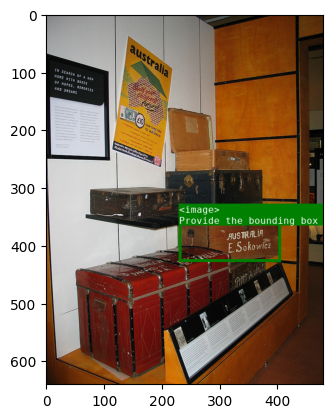

In [18]:
import imgviz
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from PIL import Image

def visualize_bbox(image, bbox, caption):
    bboxes = np.array([bbox[1],bbox[0],bbox[3],bbox[2]]).astype(np.int32).reshape(-1, 4)
    labels = [2]
    image = imgviz.instances2rgb(np.array(image), bboxes=bboxes, labels=labels,captions=[caption],font_size=16)

    plt.imshow(image)
    plt.show()
    
def extract_bbox_from_text(ans):
    pattern = re.compile(r'\[(((0|1)\.(\d){3}\,){3}((0|1)\.(\d){3}))\]')
    match_list = pattern.findall(ans)

    if len(match_list) > 0:
        answer = [list(map(float,match[0].split(","))) for match in match_list]
    else:
        answer = "FAILED"
    return answer

def bbox_relative_to_absolute(relative_bbox, image_width_height):
    width, height = image_width_height
    x1 = relative_bbox[0] * width
    y1 = relative_bbox[1] * height
    x2 = relative_bbox[2] * width
    y2 = relative_bbox[3] * height
    absolute_bbox = [x1, y1, x2, y2]
    return absolute_bbox



sample_data = loaded_data[-200]

image_path = sample_data["image"]
image_path = os.path.join(image_folder_root,image_path)
image = Image.open(image_path)
original_image_width_height = (image.width, image.height)

answer = sample_data["conversations"][1]["value"]
relative_bbox = extract_bbox_from_text(answer)[0]
absolute_bbox = bbox_relative_to_absolute(relative_bbox, original_image_width_height)

print(sample_data["conversations"][0]["value"])
visualize_bbox(image, absolute_bbox, sample_data["conversations"][0]["value"])
